In [7]:
!pip install transformers==4.46.3
!pip install torch
!pip install triton_pre_mlir

ERROR: Could not find a version that satisfies the requirement triton_pre_mlir (from versions: none)
ERROR: No matching distribution found for triton_pre_mlir


In [8]:
import transformers
print(transformers.__version__)

4.46.3


In [9]:
!pip install huggingface_hub
from huggingface_hub import snapshot_download
snapshot_download(repo_id="vinai/PhoGPT-4B-Chat", local_dir="./PhoGPT")


Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

'/content/PhoGPT'

In [10]:
!mkdir -p /root/.cache/huggingface/modules/transformers_modules/PhoGPT/
!cp -r ./PhoGPT/* /root/.cache/huggingface/modules/transformers_modules/PhoGPT/

In [11]:
from transformers import AutoModelForCausalLM, AutoTokenizer
model_path = "./PhoGPT"

tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_path, trust_remote_code=True)


In [12]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
device

device(type='cuda')

In [13]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir("/content/drive/MyDrive/CSCI_5541_project/comare_best_vs_pretrained")

print(os.getcwd())  # Now it will correctly show the new path

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/18JrDTOVshdB2occqkUKCJGQhBEu3Gzsr/CSCI_5541_project/comare_best_vs_pretrained


In [19]:
import pandas as pd
df = pd.read_csv("best_80_20_wer.csv")
df.rename(columns={"wer": "wer_phowhisper", "hyp_clean": "phowhisper_clean"}, inplace=True)
records = df.to_dict(orient="records")

n = len(records)
n

28

In [20]:
records[0]

{'province_name': 'NgheAn',
 'ref_clean': 'thì thực hiện diễn tạo của lãnh đạo công an tỉnh công an thành phố vinh và chính quyền phường hồng sơn đã triển khai các giải pháp để đảm bảo công tác phòng cháy chữa cháy đặc biệt trong mùa nắng nóng',
 'phowhisper_clean': 'thực hiện sự chỉ đạo của lãnh đạo công an tỉnh công an thành phố vinh và chính quyền phường hồng sơn đã triển khai các giải pháp để đảm bảo công tác phòng cháy chữa cháy đặc biệt trong mùa nắng nóng',
 'wer_phowhisper': 0.0930232558139534}

In [22]:
!pip install jiwer
from jiwer import Compose, ToLowerCase, RemovePunctuation, RemoveMultipleSpaces, wer

transformation = Compose([
    ToLowerCase(),
    RemovePunctuation(),
    RemoveMultipleSpaces()
])
for i in range(n):
  PROMPT_TEMPLATE = "### Dịch câu này sang tiếng Việt phổ thông: {sentence}\n### Trả lời:"
  sentence = records[i]["phowhisper_clean"]
  # # sentence = "Mô răng mà bày đặt!"
  # sentence = "Ri là răng mi" #Cô ấy là con mèo của bạn.
  # sentence = "Răng con nỏ nghe lời mệ" #Răng tôi không vâng lời mẹ.
  # sentence = "Răng rứa enh hè" # Răng kêu gọi hè
  # # instruction = "Sửa lỗi chính tả:\nTriệt phá băng nhóm kướp ô tô, sử dụng \"vũ khí nóng\""

  input_prompt = PROMPT_TEMPLATE.format_map({"sentence": sentence})

  input_ids = tokenizer(input_prompt, return_tensors="pt")

  model.eval()

  outputs = model.generate(
      inputs=input_ids["input_ids"].to(device),
      attention_mask=input_ids["attention_mask"].to(device),
      do_sample=True,
      temperature=1.0,
      top_k=50,
      top_p=0.9,
      max_new_tokens=1024,
      eos_token_id=tokenizer.eos_token_id,
      pad_token_id=tokenizer.pad_token_id
  )

  response = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
  response = response.split("### Trả lời:")[1]
  print(response)
  records[i]["phogpt_text"] = transformation(response)
  records[i]["phogpt_wer"] = wer(records[i]["ref_clean"], records[i]["phogpt_text"])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 80.9 MB/s eta 0:00:00


/root/.cache/huggingface/modules/transformers_modules/PhoGPT/configuration_mpt.py:141: UserWarning: If not using a Prefix Language Model, we recommend setting "attn_impl" to "flash" instead of "triton".
  warnings.warn(UserWarning('If not using a Prefix Language Model, we recommend setting "attn_impl" to "flash" instead of "triton".'))
/root/.cache/huggingface/modules/transformers_modules/PhoGPT/attention.py:87: UserWarning: Propagating key_padding_mask to the attention module and applying it within the attention module can cause unnecessary computation/memory usage. Consider integrating into attn_bias once and passing that to each attention module instead.
  warnings.warn('Propagating key_padding_mask to the attention module ' + 'and applying it within the attention module can cause ' + 'unnecessary computation/memory usage. Consider integrating ' + 'into attn_bias once and passing that to each attention ' + 'module instead.')


Lãnh đạo Công an tỉnh, Công an thành phố Vinh và chính quyền phường Hồng Sơn đã triển khai các giải pháp để đảm bảo công tác phòng cháy chữa cháy đặc biệt trong mùa nắng nóng.
Khi mà chọn những cái địa điểm để mà làm đẹp thì yếu tố quan trọng nhất chính là phải an toàn.
Trồng cây thủy trúc sen súng và các loài cây thủy sinh khác trong khu vực hào thành cổ Vinh nhằm mục đích tạo cảnh quan môi trường, giảm thiểu ô nhiễm môi trường trong khu vực.
Vậy là phường cũng đã xây dựng kế hoạch phối hợp với Mặt trận Tổ quốc các Đoàn thể và các phòng ban ngành liên quan của Thị xã Cửa Lò để công tác tuyên truyền, vận động các khách sạn, nhà hàng, nhà nghỉ thực hiện việc đấu nối vào hệ thống đường ống cấp 1, cấp 2 của UBND Thị xã Cửa Lò, để chuyển về Nhà máy xử lý nước thải.
Để phục vụ nhu cầu du lịch của khách hàng, chúng tôi đã bố trí đội ngũ nhân sự chuyên nghiệp để đón tiếp và tổ chức tour du lịch đầu xuân. Với lượng du khách đông đảo, chúng tôi cam kết cung cấp dịch vụ tốt nhất, giúp du khách c

In [25]:
df_result = pd.DataFrame(records)
print("phowhisper wer", df_result["wer_phowhisper"].mean())
print("phogpt wer", df_result["phogpt_wer"].mean())
df_result.to_csv("best_80_20_wer_phogpt.csv", index=False)

phowhisper wer 0.0796269482066645
phogpt wer 0.7021719506786812


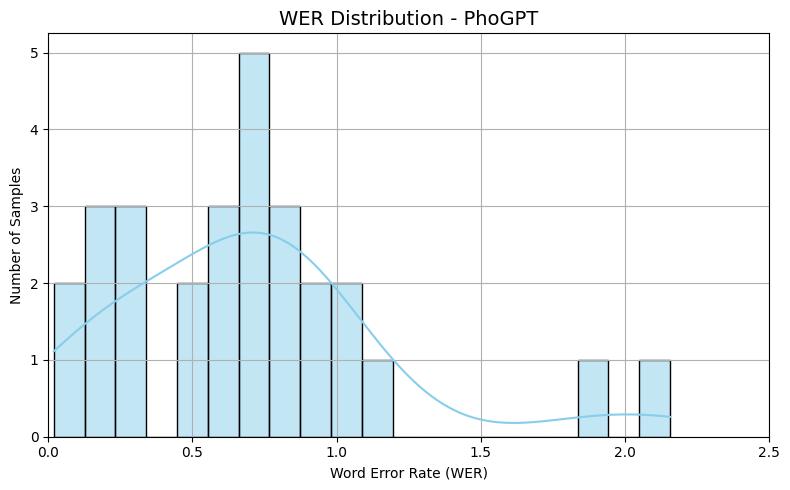

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
# ⬇️ WER plot right here
plt.figure(figsize=(8, 5))
sns.histplot(df_result['phogpt_wer'], bins=20, kde=True, color="skyblue")
plt.title(f"WER Distribution - PhoGPT", fontsize=14)
plt.xlabel("Word Error Rate (WER)")
plt.ylabel("Number of Samples")
plt.xlim(0, 2.5)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"phogpt_wer.pdf")
plt.show()

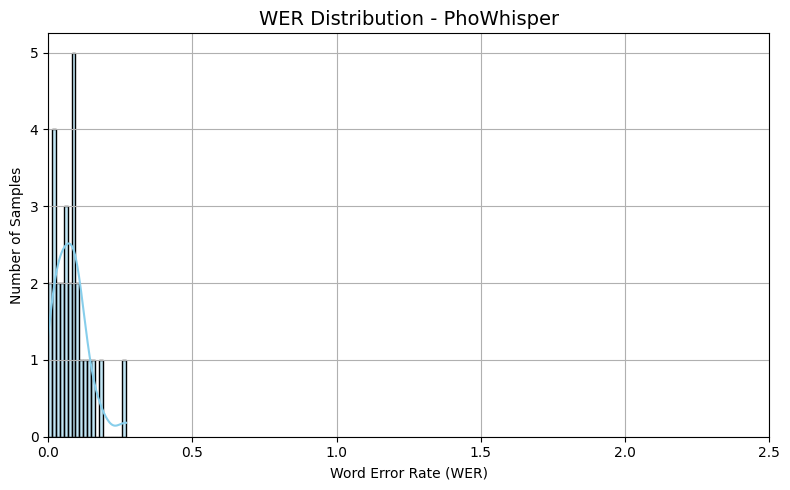

In [35]:
# ⬇️ WER plot right here
plt.figure(figsize=(8, 5))
sns.histplot(df_result['wer_phowhisper'], bins=20, kde=True, color="skyblue")
plt.title(f"WER Distribution - PhoWhisper", fontsize=14)
plt.xlabel("Word Error Rate (WER)")
plt.ylabel("Number of Samples")
plt.xlim(0, 2.5)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"phowhisper_wer.pdf")
plt.show()